#Stock Correlation Matrix
In this notebook, we'll be taking a universe of Quantopian's built in Q1500US filter. These 1500 stocks are chosen by the following criteria.

_(Q1500US) A default universe containing approximately 1500 US equities each day.Constituents are chosen at the start of each month by selecting the top 1500 “tradeable” stocks by 200-day average dollar volume, capped at 30% of equities allocated to any single sector._

In [83]:
from quantopian.pipeline.filters import Q1500US, Q500US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.data.builtin import USEquityPricing

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
import seaborn

##Getting the Data
We define our pipeline to fetch the end-of-day closing price of the 1500 equities from the beginning of 2016 to the beginning of 2018.

In [3]:
def make_pipeline():
    universe = Q1500US()    
    return Pipeline(
    columns={
          'close': USEquityPricing.close.latest
    },
    screen=universe)

In [4]:
start = '2016-01-01'
end = '2018-01-01'
my_pipe = make_pipeline()
result = run_pipeline(my_pipe, start, end)

We remove any duplicated equities to avoid mergin issues when we combine everything in a single table later on.

In [22]:
result = result[~result.index.duplicated()]

##The Resulting Data
After running the pipeline and gathering data, we end up with multi-indexed Series object. The first index represents each day during the entire time period whereas the second index represents the equities. As a result, we get a huge table with 752 215 rows since we are getting 1500 stock closing prices for two years worth of trading days.

In [23]:
result.shape

(752215, 1)

In [24]:
result[:10]

close
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])      9.86
                          Equity(24 [AAPL])   105.23
                          Equity(53 [ABMD])    90.24
                          Equity(62 [ABT])     44.91
                          Equity(67 [ADSK])    60.92
                          Equity(76 [TAP])     93.92
                          Equity(114 [ADBE])   93.91
                          Equity(122 [ADI])    55.32
                          Equity(128 [ADM])    36.67
                          Equity(161 [AEP])    58.27

##Combining it into one 2-D array.
We want to modify the table so the resulting table will be only indexed by the date and the equities will appear as columns. We first get the date index from the original table. We then get all the equity symbols from the second index and filtering it out so there are only unique values of those.

In [21]:
dates = result.index.get_level_values(0).unique()
dates[:10]

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15'],
              dtype='datetime64[ns, UTC]', freq=None)

In [33]:
equities = result.index.get_level_values(1).unique()

In [34]:
equities[:10]

array([Equity(2 [ARNC]), Equity(24 [AAPL]), Equity(53 [ABMD]),
       Equity(62 [ABT]), Equity(67 [ADSK]), Equity(76 [TAP]),
       Equity(114 [ADBE]), Equity(122 [ADI]), Equity(128 [ADM]),
       Equity(161 [AEP])], dtype=object)

We combine it all by first creating an empty DataFrame with out dates as the index. We then populate that DataFrame with the Series of each individual stock's closing prices by taking the cross section.

In [100]:
data_time_index = pd.DataFrame(index=dates)
for equity in equities:
    data_time_index[equity.symbol] = result.xs(equity, level=1)

Below is an example of the cross section of one equity plotted on graph.

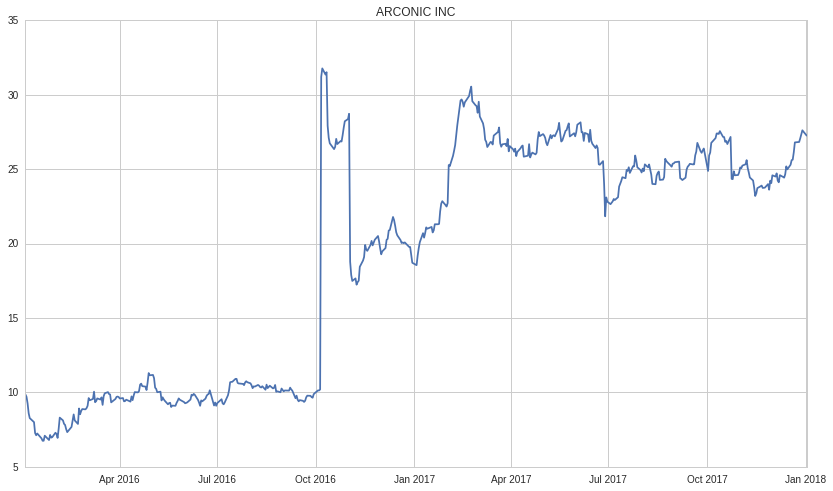

In [101]:
stock_time_series = result.xs(equities[0], level=1)
plt.title(equities[0].asset_name)
plt.plot(stock_time_series)

The resulting DataFrame looks a little something like this below.

In [102]:
data_time_index = data_time_index.dropna(axis=1)
data_time_index[:10]

,ARNC,AAPL,ABMD,ABT,ADSK,TAP,ADBE,ADI,ADM,AEP,...,SHOP,FIT,WRK,CC,ENR,KHC,PYPL,BUFF,FDC,HPE
2016-01-04 00:00:00+00:00,9.860,105.23,90.24,44.91,60.920,93.92,93.91,55.32,36.67,58.27,...,25.79,29.50,45.62,5.37,34.06,72.75,36.200,18.720,16.030,15.18
2016-01-05 00:00:00+00:00,9.700,105.33,85.16,42.93,60.300,92.23,91.96,54.44,35.85,58.36,...,25.71,29.73,45.52,5.49,34.70,72.70,34.750,18.320,15.605,15.13
2016-01-06 00:00:00+00:00,9.260,102.70,84.99,42.92,60.390,92.66,92.33,54.03,36.24,58.81,...,25.33,24.27,45.49,5.42,34.55,73.38,34.305,17.850,15.910,15.03
2016-01-07 00:00:00+00:00,8.600,100.70,85.30,42.57,59.530,90.77,91.02,51.73,35.37,59.04,...,25.26,22.91,44.23,5.11,34.36,73.54,33.990,17.980,15.460,14.78
2016-01-08 00:00:00+00:00,8.273,96.54,81.92,41.54,55.970,90.38,89.10,50.42,34.52,58.34,...,24.70,21.50,43.79,4.75,33.11,71.90,33.130,17.440,14.530,13.72
2016-01-11 00:00:00+00:00,8.068,96.98,84.64,40.65,55.070,89.19,87.84,49.98,34.39,58.24,...,24.93,21.54,41.91,4.78,31.94,71.18,32.700,16.820,14.150,13.55
2016-01-12 00:00:00+00:00,8.000,98.53,85.00,40.73,55.220,88.47,89.39,51.17,34.16,58.76,...,23.89,18.85,39.75,4.38,31.40,72.25,33.030,16.350,13.840,13.26
2016-01-13 00:00:00+00:00,7.270,99.99,88.32,41.22,54.785,89.56,89.82,51.65,34.27,58.16,...,23.71,19.62,38.35,3.90,31.96,73.23,33.080,16.110,13.750,13.26
2016-01-14 00:00:00+00:00,7.120,97.41,85.83,40.28,50.890,87.59,88.30,50.12,33.46,57.96,...,21.38,19.83,37.95,3.29,31.39,70.81,32.130,16.020,13.710,12.75
2016-01-15 00:00:00+00:00,7.240,99.52,87.80,41.10,52.650,86.74,89.79,50.50,33.36,59.13,...,20.62,18.86,38.49,3.51,31.43,70.74,32.870,16.329,14.260,12.99


##Creating the correlation table.
We transform the array into a correlation table using Pandas' built-in function

In [103]:
corr_matrix = data_time_index.pct_change().corr()
corr_matrix = corr_matrix.iloc[100:135, 100:150]
corr_matrix.head()

,CRUS,CSCO,CSL,CSX,CTAS,CTB,CTL,CMI,CUZ,CW,...,EA,ESRX,ESV,ETN,ETR,EXPD,F,CLGX,FAST,FNB
CRUS,1.000000,0.178692,0.333903,0.170558,0.198271,0.151190,0.147336,0.248719,0.115356,0.259184,...,0.209703,0.087771,0.130798,0.230415,0.046520,0.184013,0.077424,0.256280,0.227319,0.258092
CSCO,0.178692,1.000000,0.344627,0.255040,0.322770,0.254785,0.311884,0.334144,0.204609,0.311753,...,0.179874,0.272641,0.148651,0.394024,0.113964,0.316979,0.356708,0.260421,0.316683,0.318532
CSL,0.333903,0.344627,1.000000,0.303813,0.355873,0.268637,0.185904,0.410801,0.185444,0.465653,...,0.139557,0.249126,0.233904,0.466020,0.156377,0.375174,0.391517,0.229608,0.467379,0.457442
CSX,0.170558,0.255040,0.303813,1.000000,0.269044,0.153290,0.095473,0.411821,0.106467,0.267050,...,0.105033,0.234198,0.233133,0.380443,0.012379,0.299614,0.335904,0.138555,0.297036,0.299540
CTAS,0.198271,0.322770,0.355873,0.269044,1.000000,0.255169,0.147979,0.332034,0.184459,0.362198,...,0.197096,0.223171,0.097271,0.352136,0.195130,0.316710,0.263696,0.298518,0.302469,0.305614


##Visualizing the table with a heatmap.
We use seaborn to plot the values on a heatmap. We filter out the upper triangle of the array to remove any duplicate values.

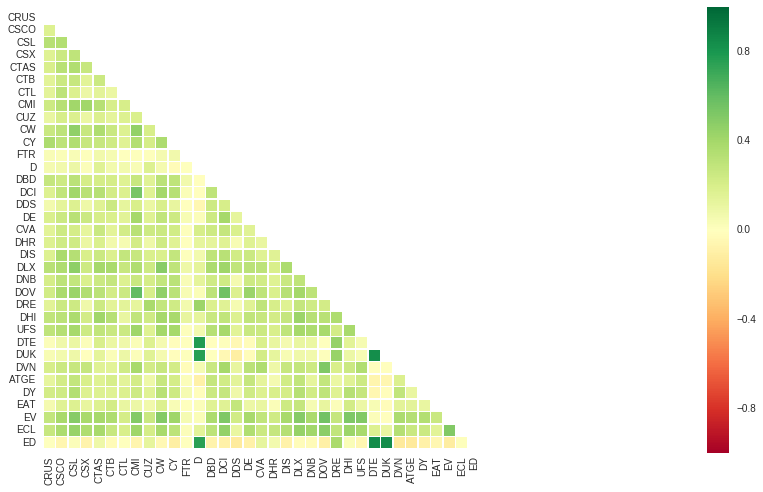

In [104]:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

seaborn.heatmap(corr_matrix,cmap='RdYlGn' , xticklabels=corr_matrix.index, 
                yticklabels=corr_matrix.index, center=0, mask=mask, square=True, linewidths=.5
                )

##Examples of correlated equities given from heatmap.

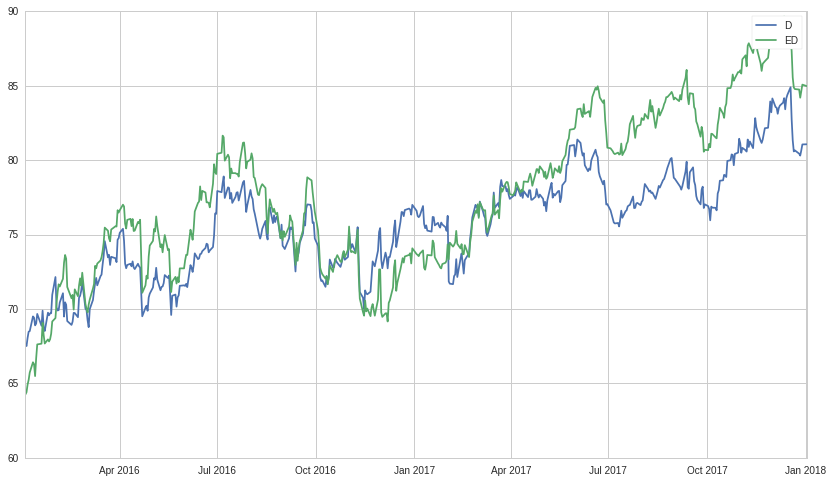

In [114]:
plt.plot(data_time_index['D'], label='D')
plt.plot(data_time_index['ED'], label='ED')
plt.legend()

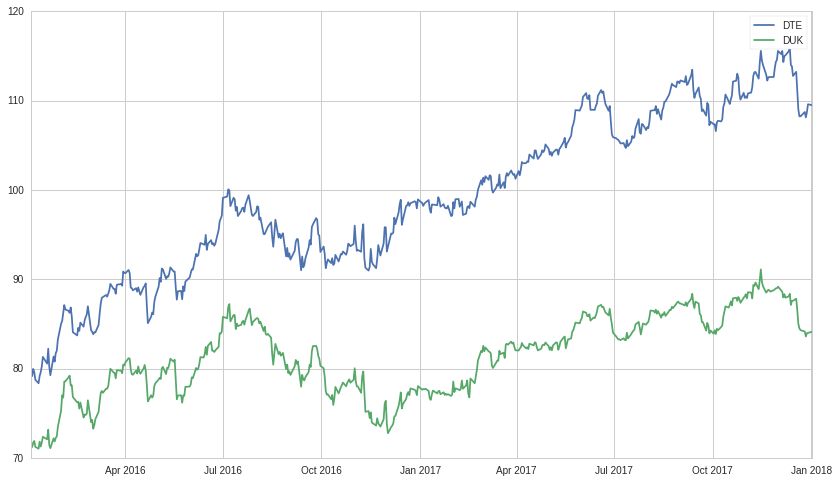

In [115]:
plt.plot(data_time_index['DTE'], label='DTE')
plt.plot(data_time_index['DUK'], label='DUK')
plt.legend()